# Analysis of Global Production Crops Over Time
## Introduction
### Background and Context
Agricultural production is the foundation of the global economy. Globally it provides jobs to over 1 billion people (Map of the month 2020) and provides food security to billions. Without agriculture, there would be no way to support our current population numbers and density. Without affordable and efficient access to food, economies would collapse. The importance of agricultural production cannot be overstated. 
As population continues to grow, so must food production. As we enter an era of increased variance in global temperatures, weather patterns, and natural disasters understanding the nature of food production trends will be necessary in assessing the health of our agricultural industries. Forecasting can help to inform law/policy makers, it can help to optimize resource allocation, and inform supply chains.
Time series analysis is a statistical and machine learning technique used to model trends and forecast future values of temporal data. This type of analysis will be effective in understanding, describing, and predicting trends in agricultural data production. Time series analysis techniques such as Autoregressive Integrated Moving Average (ARIMA), Seasonal ARIMA (SARIMA), Long Short-Term Memory (LSTM) networks, and Facebook Prophet, can be employed to model and predict crop production trends. Each of these methods offers unique advantages and limitations, depending on the underlying data structure, model complexity, and forecasting requirements.
### Objectives of the Study
This study aims to apply different time series analysis techniques to the FAOSTAT production indices dataset, obtained from the Food and Agriculture Organization of the United Nations (FAO), to forecast crop production trends. The results will provide insights into the most appropriate time series forecasting method for predicting crop production trends and offer valuable input for decision-making in agricultural planning and management.

In [133]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import math
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error

# Set seaborn theme for plots
sns.set_theme(style="darkgrid")

# Ignore warnings
warnings.filterwarnings("ignore")


## Project Dataset
### FAOSTAT Crops and Livestock Products Dataset
The Food and Agriculture Organization (FAO) is a United Nations agency dedicated to leading international efforts to combat hunger. FAO's mission is to ensure food security for all, enabling individuals to have consistent access to sufficient, high-quality food to maintain active and healthy lives.
The FAOSTAT data portal offers a diverse range of data on subjects such as food production, food security, trade, climate change, and other relevant indicators. In this study, we will concentrate on the "Crops and Livestock Products" dataset, which encompasses variables like country, year, and specific crop production data.
### Data Collection Process
The FAOSTAT portal provides a user-friendly interface for data extraction, allowing both bulk data downloads and pre-filtered selections based on specific parameters. For this study, we will utilize the pre-filtering option to obtain data specific to our target crop, location, and time series for modeling purposes. The extracted data will be saved in CSV format, facilitating further manipulation and modeling using Python3.


In [134]:
# parent directory
parent = os.path.dirname(os.getcwd())

# load main csv
wine = pd.read_csv("faostat_wine.csv")
#temp = pd.read_csv("FAOSTAT_temp_change.csv")
#rain = pd.read_csv("")

### Data Pre-processing
Before starting our analysis, we cleaned up the CSV data from the FAOSTAT portal with the following steps:
- Reviewed the columns in the data table to check for irrelevant columns.
- Used python to check for the unique values for units in the dataset, and confirmed that the wine production data is all reported in tonnes, with no other units appearing.
- Converted the Year text values into Datetime format.
- Removed any extraneous records from the table by discarding any rows with null data in the Value column.
- Dropped unnecessary columns so only the Area, Year, and Value columns remain.
- Indexed the Year column in the data tables.
With these steps complete, we obtain cleaned data tables with annual wine production and temperature variation for our selected countries (Italy, Fance, Spain, and the USA).

In [136]:
# Confirm only one unit in dataset
set(wine["Unit"].unique())

{'tonnes'}

In [137]:
# Set datatype of Year column to datetime
wine["Year Code"] = pd.to_datetime(wine["Year Code"],format="%Y")
temp["Year Code"] = pd.to_datetime(temp["Year Code"],format="%Y")

# Remove rows with null values in "value" column
wine = wine[wine["Value"].notna()]
temp = temp[temp["Value"].notna()]

# Remove unnecessary columns
wine = wine[["Area","Year Code","Value"]]
temp = temp[["Area","Year Code","Value"]]

# Datetime index dataframes
wine = wine.set_index("Year Code")
temp = temp.set_index("Year Code")

## Assumption Testing for Time Series Analysis
### Stationarity 

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

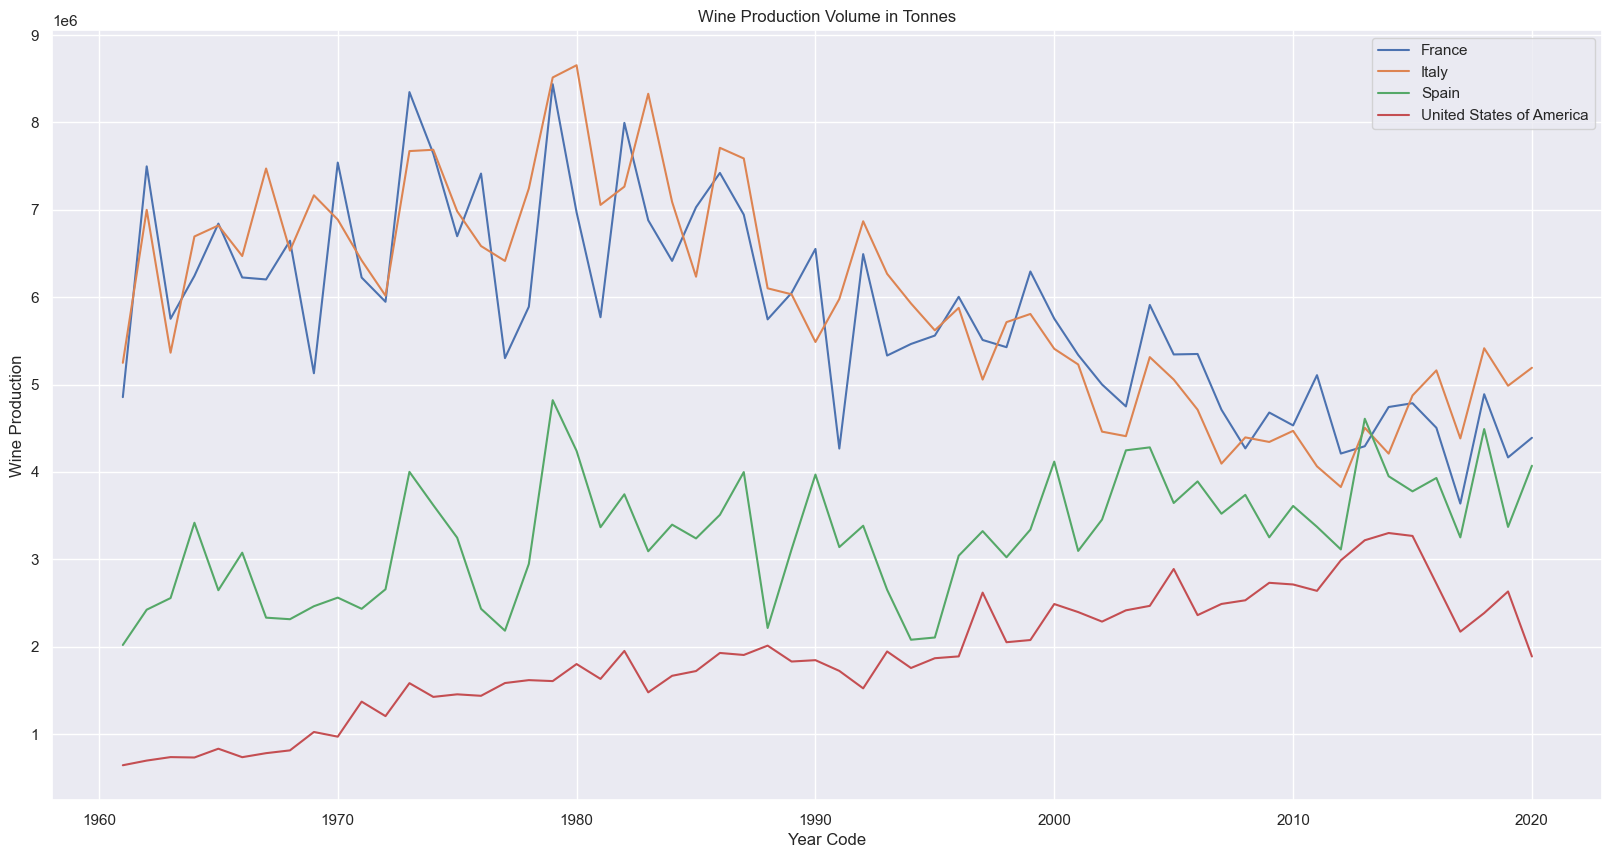

In [138]:
plt.figure(figsize=(20,10))
sns.lineplot(data=wine, y='Value', hue='Area',x=wine.index)
plt.title('Wine Production Volume in Tonnes')
plt.ylabel('Wine Production')
plt.legend(loc='best')
plt.show()

In [80]:
for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value'].values)
    print(f"{country} P-value: ", round(result[1], 4))    

France P-value:  0.7953
Italy P-value:  0.3945
Spain P-value:  0.0001
United States of America P-value:  0.3649


In [10]:
# Transformations
wine['Value_log'] = np.log(abs(wine.Value))
# Re-check Assumptions
for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value_log'].values)
    print(f"{country} P-value: ", result[1])

France P-value:  0.815544950873508
Italy P-value:  0.33842127200067074
Spain P-value:  0.00013479339879580578
United States of America P-value:  0.10334505474703887


Doing log transformation on the data did not fix the problem of non-stationarity, so we will try differencing on the data

In [11]:
# Transformations: Differencing
wine['Value Transform'] = 0

for country in list(wine['Area'].unique()):
    diff = np.diff(wine[wine['Area'] == country]['Value'])
    wine.loc[wine['Area'] == country, 'Value Transform'] = np.append([0], diff)

for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value Transform'].values)
    print(f"{country} P-value: {result[1]}")

France P-value: 3.364124615587017e-24
Italy P-value: 2.2284029970220713e-15
Spain P-value: 1.2463121912921445e-06
United States of America P-value: 9.443954124681106e-18


## Exploratory Data Analysis

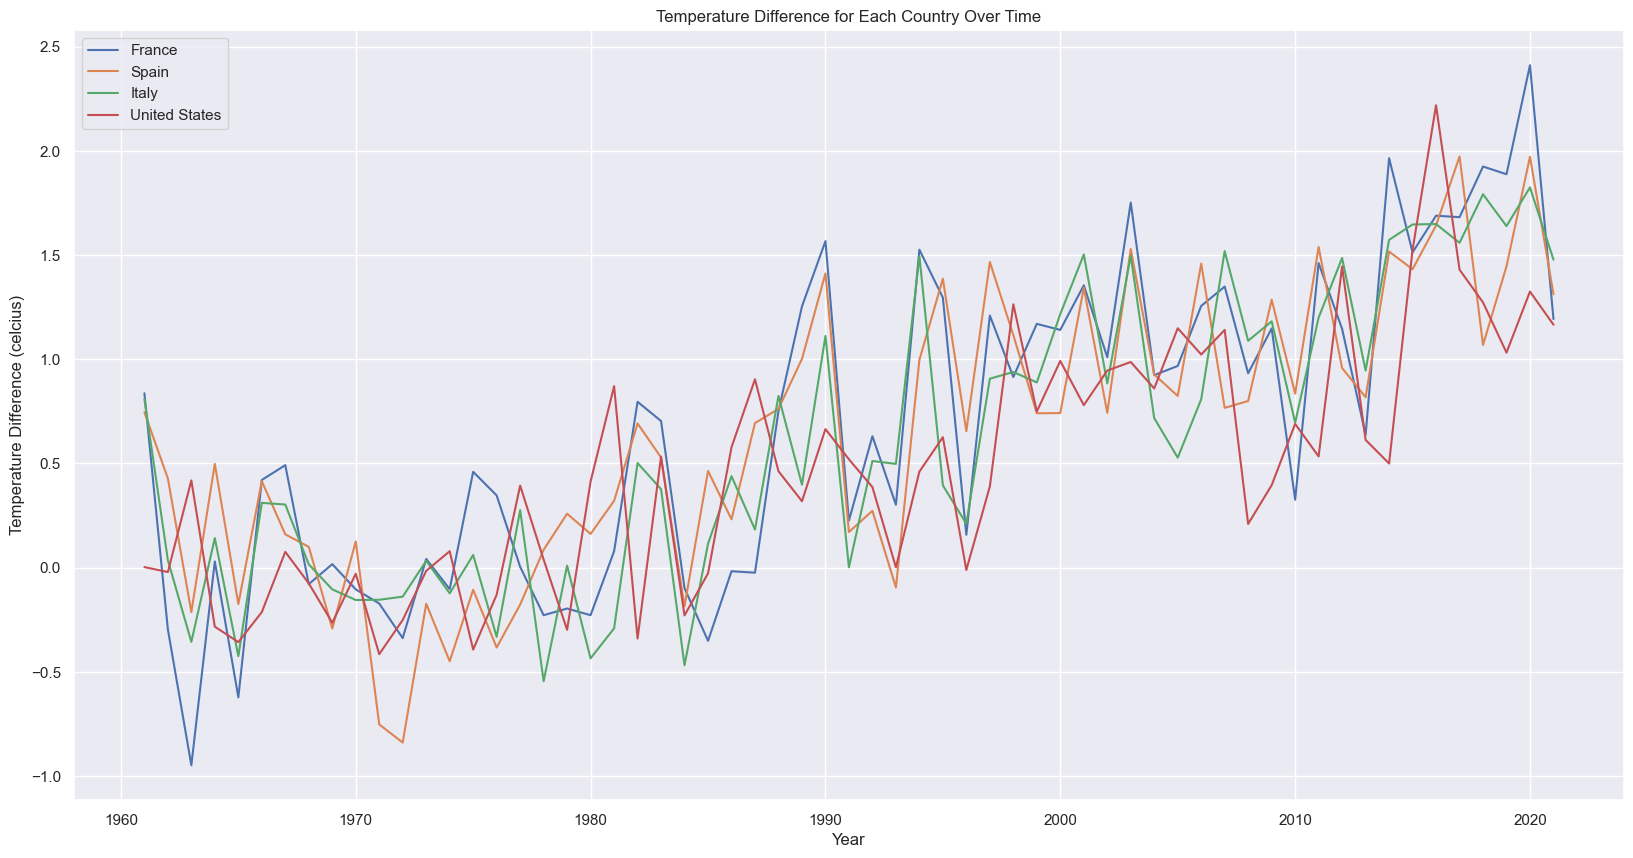

In [200]:
# Temperature
temp2 = temp.reset_index()
plt.figure(figsize=(20,10))
plt.plot(temp2[temp2['Area'] == "France"]['Year Code'], temp2[temp2['Area'] == "France"]['Value'], label = "France")
plt.plot(temp2[temp2['Area'] == "Spain"]['Year Code'], temp2[temp2['Area'] == "Spain"]['Value'], label = "Spain")
plt.plot(temp2[temp2['Area'] == "Italy"]['Year Code'], temp2[temp2['Area'] == "Italy"]['Value'], label = "Italy")
plt.plot(temp2[temp2['Area'] == "United States of America"]['Year Code'], temp2[temp2['Area'] == "United States of America"]['Value'], label = "United States")
plt.legend(loc = 'best')
plt.xlabel("Year")
plt.ylabel("Temperature Difference (celcius)")
plt.title("Temperature Difference for Each Country Over Time")
plt.show()

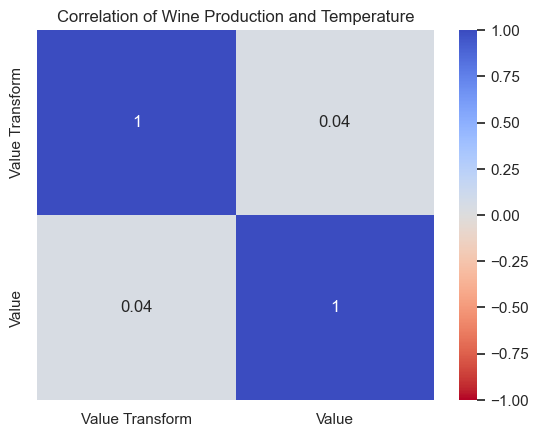

In [203]:
# Correlation Heatmap of Variables
wine2 = wine.reset_index()
corrmat = pd.DataFrame([wine2["Value Transform"], temp2["Value"]]).T.corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')
plt.title("Correlation of Wine Production and Temperature")
plt.show()

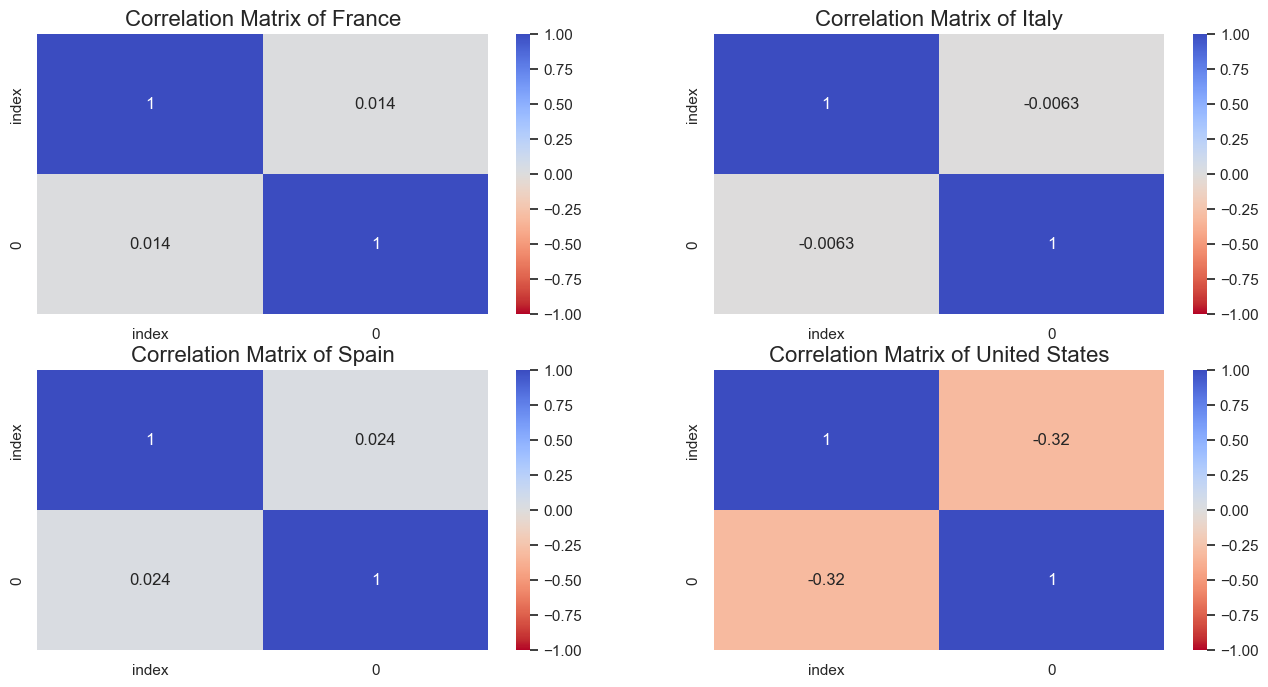

In [204]:
# Correlation Matrix for Each Country
temp2 = temp2.drop(temp2[temp2["Year Code"] == "2021-01-01"].index)
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))


corrmat2 = pd.DataFrame(np.array(wine2[wine2['Area'] == "France"]['Value Transform']), np.array(temp2[temp2['Area'] == "France"]['Value'])).reset_index().corr()

sns.heatmap(corrmat2, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0,0])
ax[0,0].set_title('Correlation Matrix of France', fontsize=16)

corrmat3 = pd.DataFrame(np.array(wine2[wine2['Area'] == "Italy"]['Value Transform']), np.array(temp2[temp2['Area'] == "Italy"]['Value'])).reset_index().corr()
sns.heatmap(corrmat3, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0,1])
ax[0,1].set_title('Correlation Matrix of Italy', fontsize=16)

corrmat4 = pd.DataFrame(np.array(wine2[wine2['Area'] == "Spain"]['Value Transform']), np.array(temp2[temp2['Area'] == "Spain"]['Value'])).reset_index().corr()
sns.heatmap(corrmat4, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1,0])
ax[1,0].set_title('Correlation Matrix of Spain', fontsize=16)

corrmat5 = pd.DataFrame(np.array(wine2[wine2['Area'] == "United States of America"]['Value Transform']), np.array(temp2[temp2['Area'] == "United States of America"]['Value'])).reset_index().corr()
sns.heatmap(corrmat5, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1,1])
ax[1,1].set_title('Correlation Matrix of United States', fontsize=16)
plt.show()

### Time Series Decomposition

We performed time series decomposition to check for strong seasonality in the data and determine if we could uncover an underlying trend after removing seasonality and noise.

#### France

In [206]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
model = 'additive'  # or 'multiplicative'
#model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequency = 4
decomposition = seasonal_decompose(wine[wine["Area"]=='France'].Value, model=model, period=frequency)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

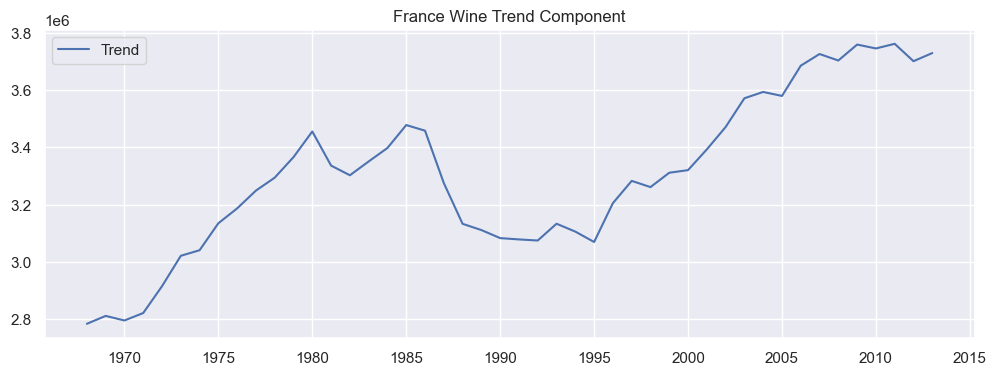

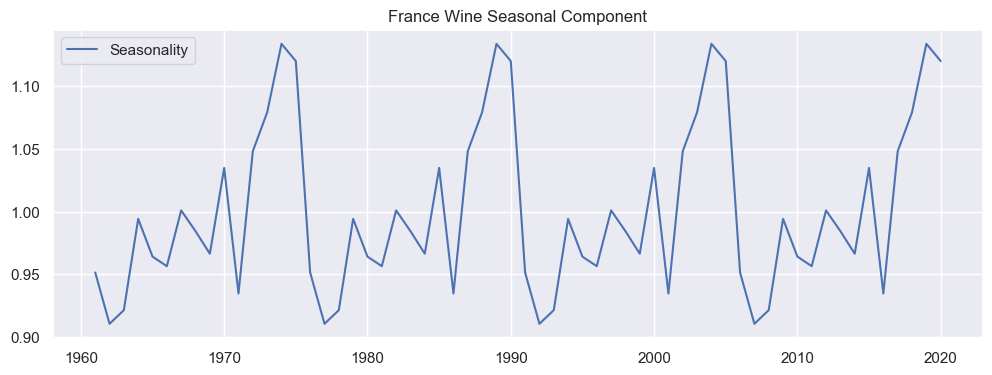

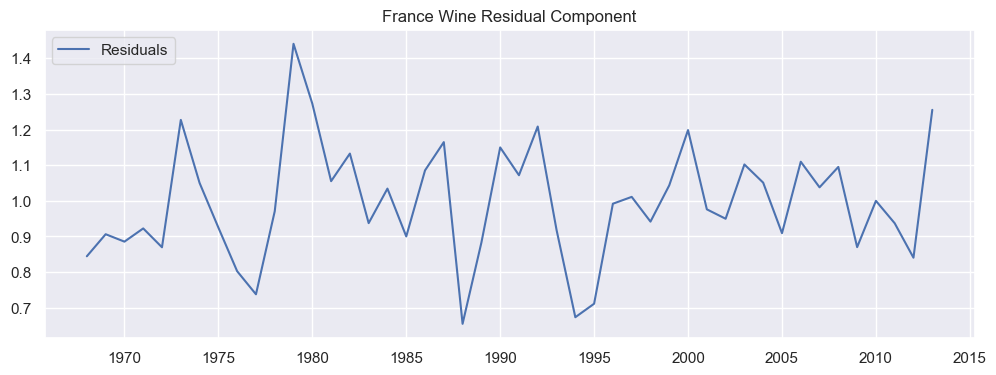

In [205]:
# 5.1 Trend Component
plt.figure(figsize=(12, 4))
plt.plot(trend, label='Trend')
plt.title("France Wine Trend Component")
plt.legend(loc='upper left')
plt.show()

# 5.2 Seasonal Component
plt.figure(figsize=(12, 4))
plt.plot(seasonal, label='Seasonality')
plt.title("France Wine Seasonal Component")
plt.legend(loc='upper left')
plt.show()

# 5.3 Residual Component
plt.figure(figsize=(12, 4))
plt.plot(residual, label='Residuals')
plt.title("France Wine Residual Component")
plt.legend(loc='upper left')
plt.show()

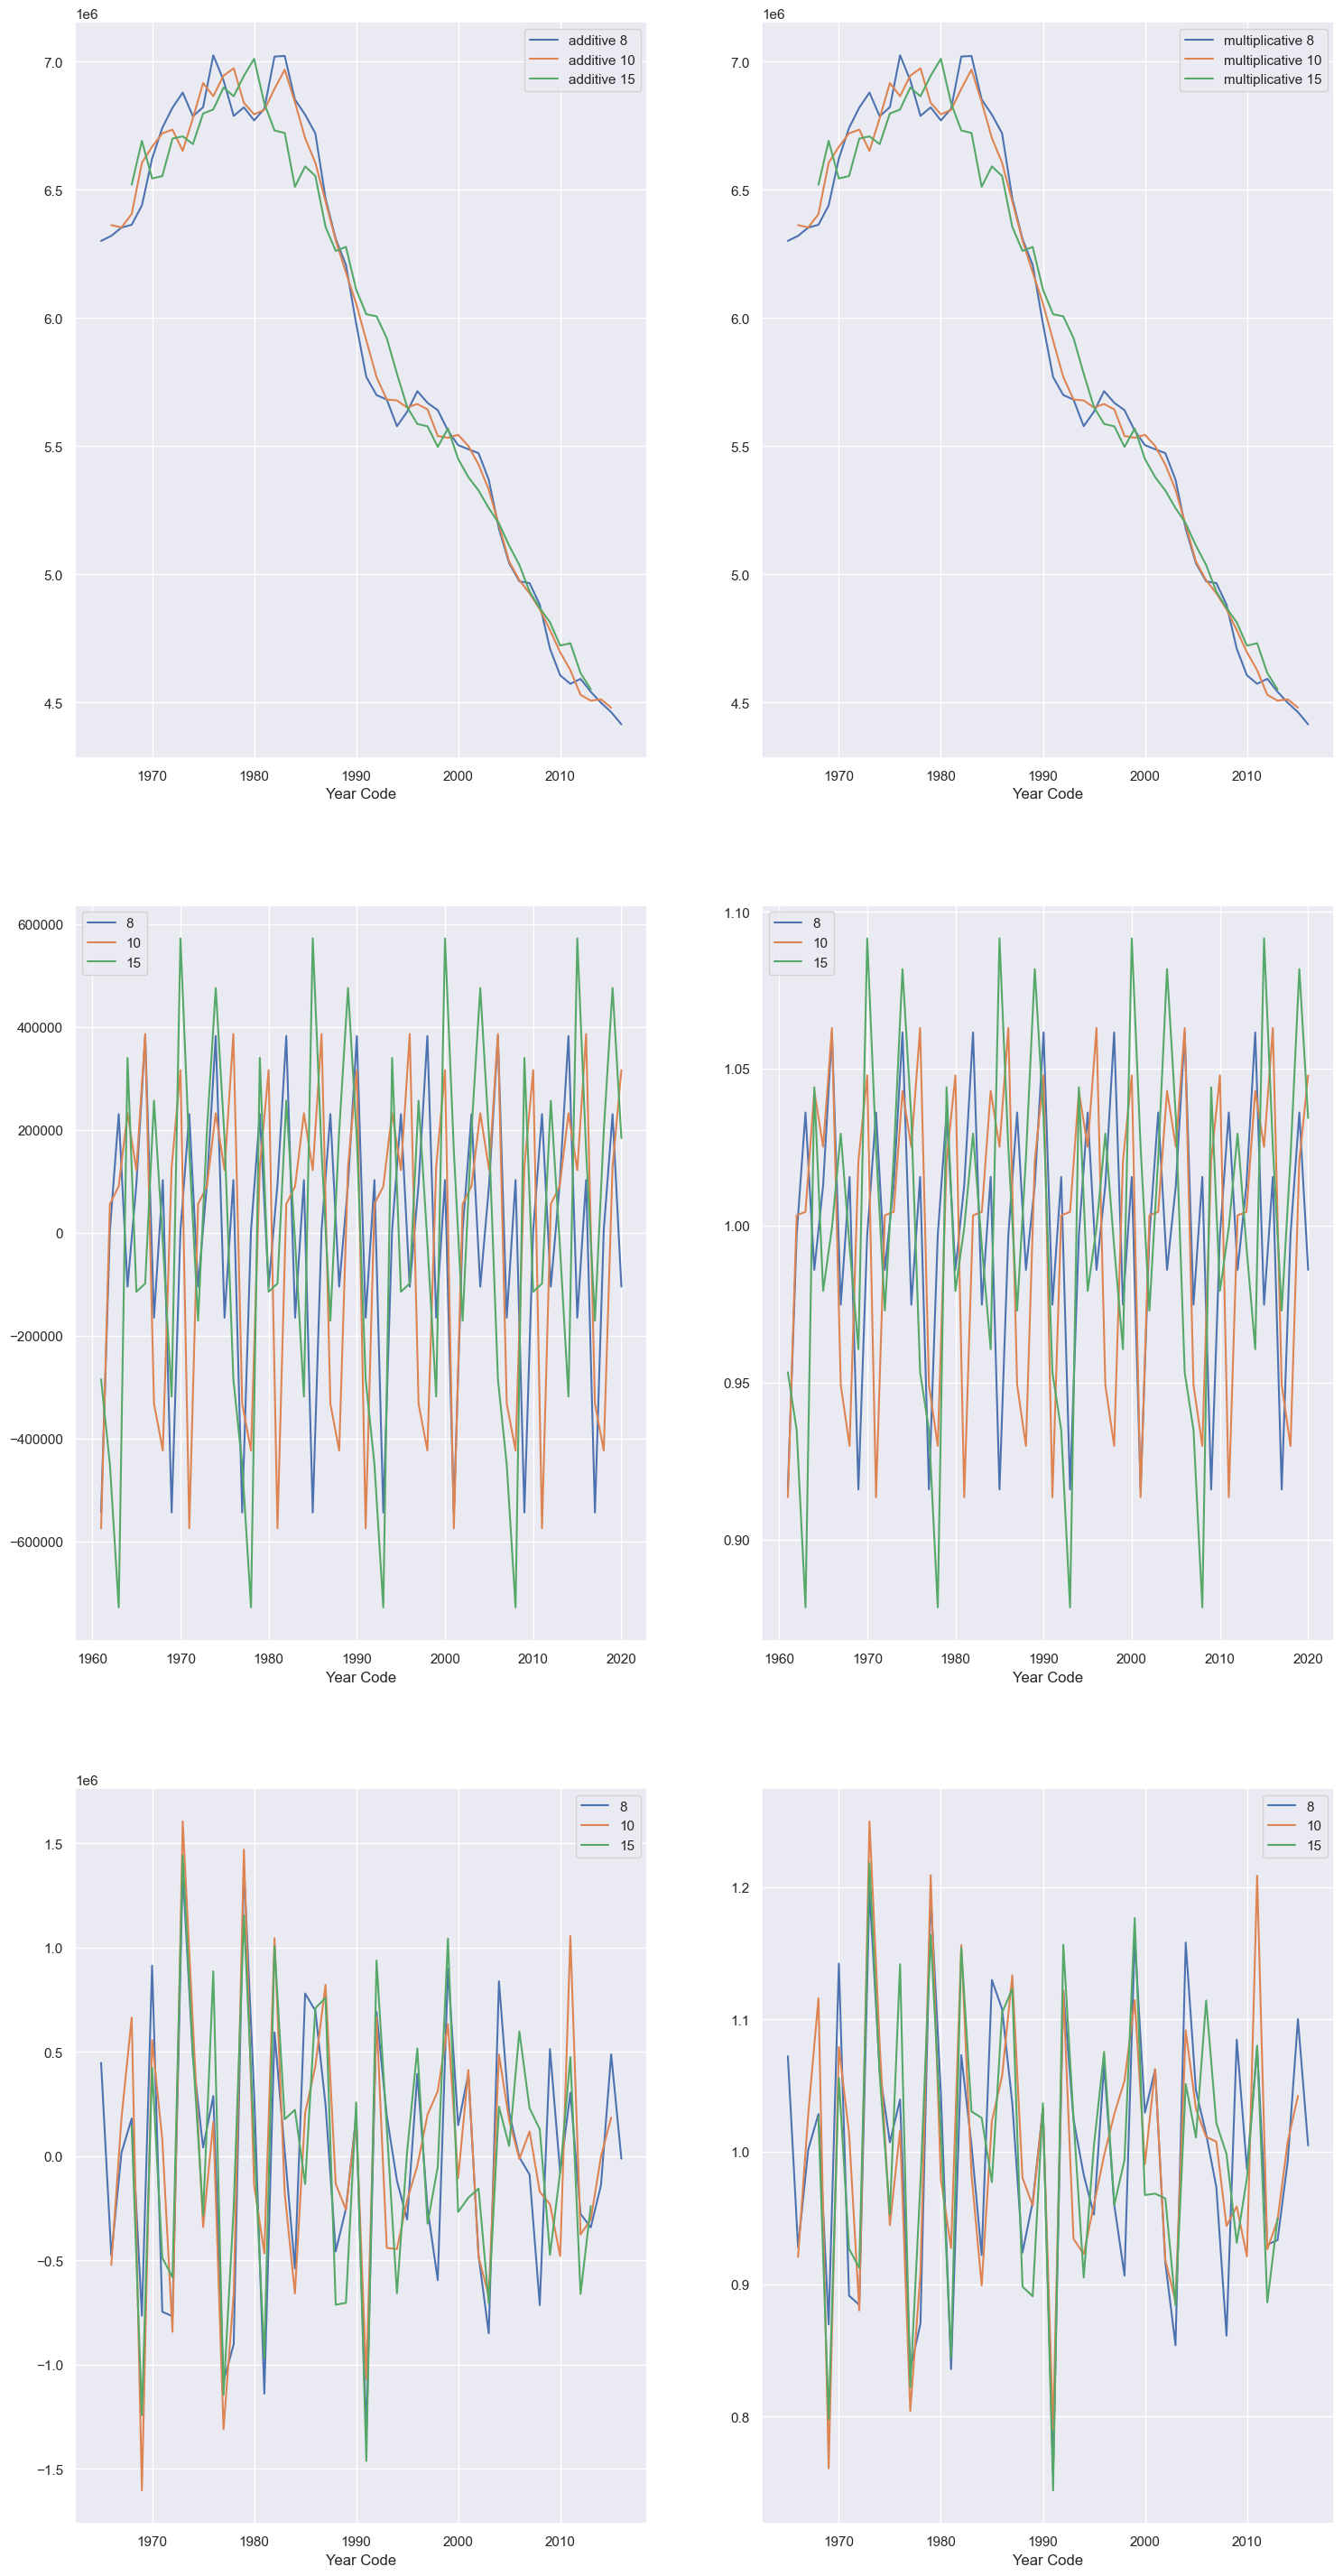

In [215]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
# model = 'additive'  # or 'multiplicative'
model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequencies = [8, 10, 15]

fig, axs = plt.subplots(3, 2, figsize=(18, 36))
for ii, model in enumerate(['additive', 'multiplicative']):
    for frequency in frequencies:
        decomposition = seasonal_decompose(wine[wine["Area"]=='France'].Value, model=model, period=frequency)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        sns.lineplot(x=trend.index, y=trend.values, ax=axs[0,ii], label=model+" "+str(frequency))
        sns.lineplot(x=seasonal.index, y=seasonal.values, ax=axs[1,ii], label=frequency)
        sns.lineplot(x=residual.index, y=residual.values, ax=axs[2,ii], label=frequency)

#sns.lineplot(x=decomposition.observed.index, y=decomposition.observed.values, ax=axs[0,0], label="original")

plt.legend()
plt.show()

#### Italy

In [ ]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
model = 'additive'  # or 'multiplicative'
#model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequency = 20
decomposition = seasonal_decompose(wine[wine["Area"]=='Italy'].Value, model=model, period=frequency)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

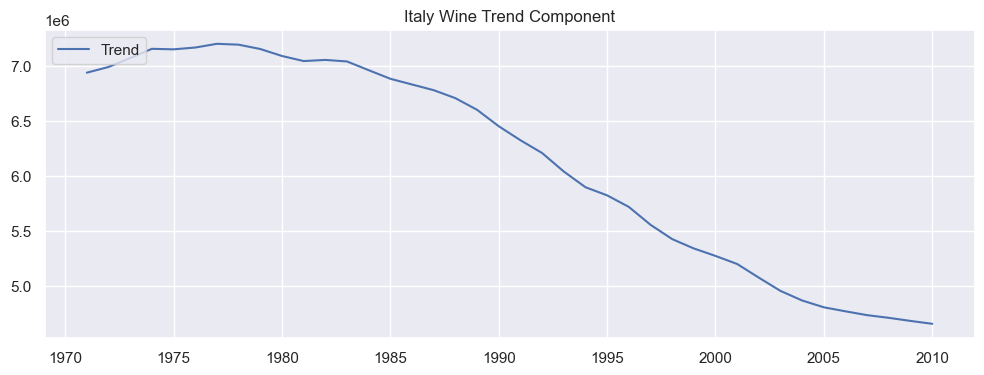

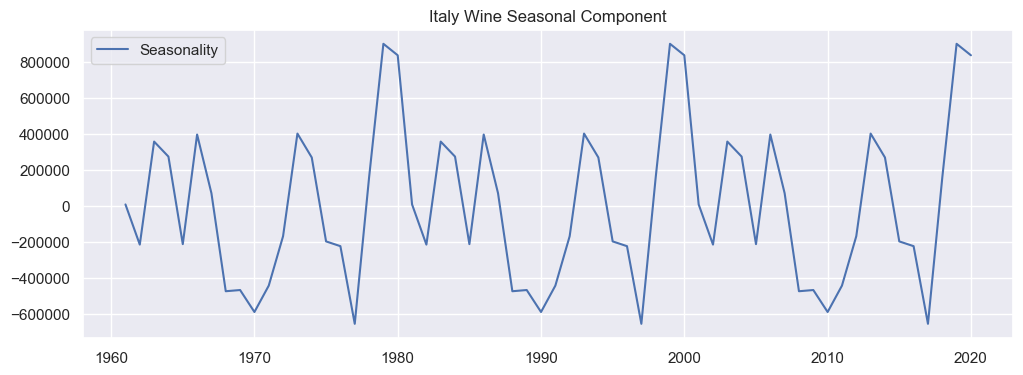

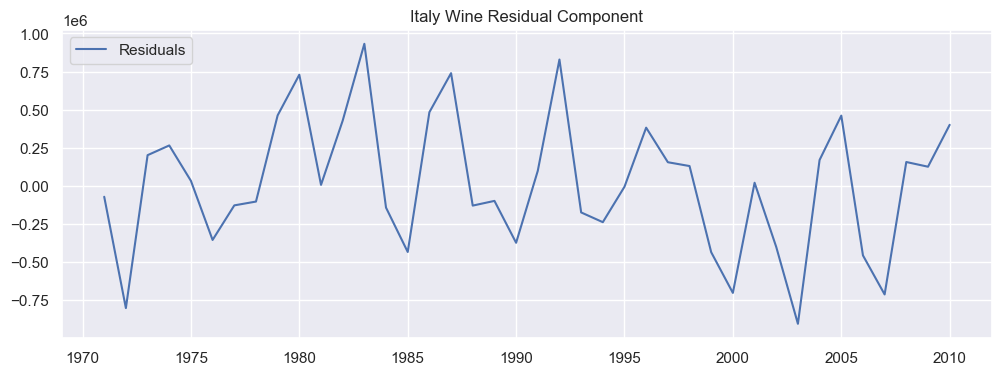

In [ ]:
# 5.1 Trend Component
plt.figure(figsize=(12, 4))
plt.plot(trend, label='Trend')
plt.title("Italy Wine Trend Component")
plt.legend(loc='upper left')
plt.show()

# 5.2 Seasonal Component
plt.figure(figsize=(12, 4))
plt.plot(seasonal, label='Seasonality')
plt.title("Italy Wine Seasonal Component")
plt.legend(loc='upper left')
plt.show()

# 5.3 Residual Component
plt.figure(figsize=(12, 4))
plt.plot(residual, label='Residuals')
plt.title("Italy Wine Residual Component")
plt.legend(loc='upper left')
plt.show()

In [ ]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
# model = 'additive'  # or 'multiplicative'
model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequencies = [1, 5, 10, 15]

fig, axs = plt.subplots(3, 2, figsize=(18, 36))
for ii, model in enumerate(['additive', 'multiplicative']):
    for frequency in frequencies:
        decomposition = seasonal_decompose(wine[wine["Area"]=='Italy'].Value, model=model, period=frequency)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        sns.lineplot(x=trend.index, y=trend.values, ax=axs[0,ii], label=model+" "+str(frequency))
        sns.lineplot(x=seasonal.index, y=seasonal.values, ax=axs[1,ii], label=frequency)
        sns.lineplot(x=residual.index, y=residual.values, ax=axs[2,ii], label=frequency)

sns.lineplot(x=decomposition.observed.index, y=decomposition.observed.values, ax=axs[0,0], label="original")

plt.legend()
plt.show()

#### Spain

In [ ]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
model = 'additive'  # or 'multiplicative'
#model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequency = 6
decomposition = seasonal_decompose(wine[wine["Area"]=='Spain'].Value, model=model, period=frequency)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


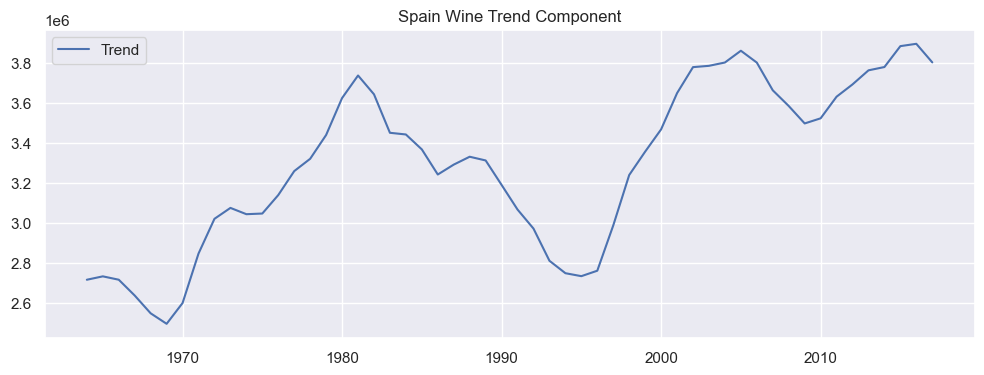

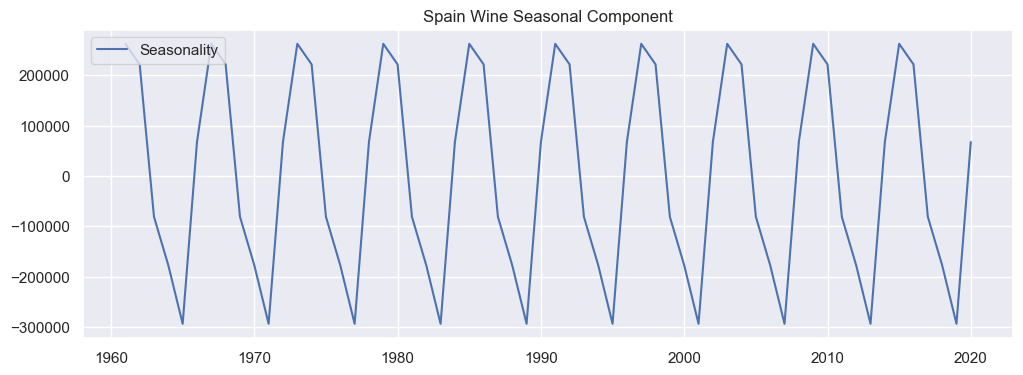

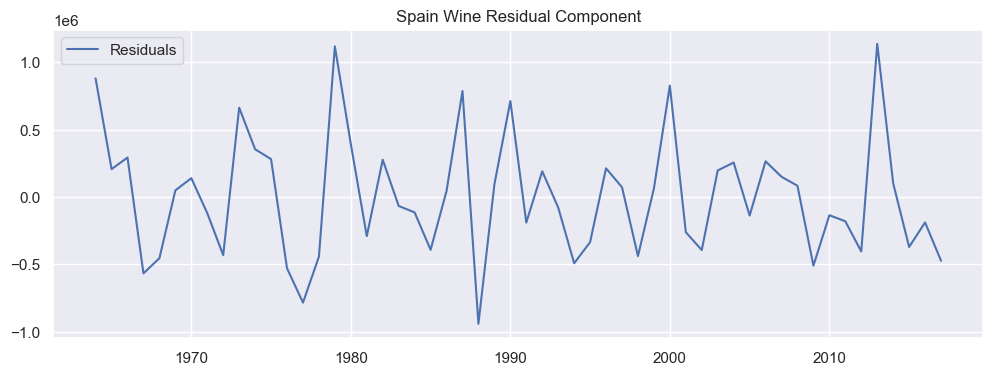

In [ ]:
# 5.1 Trend Component
plt.figure(figsize=(12, 4))
plt.plot(trend, label='Trend')
plt.title("Spain Wine Trend Component")
plt.legend(loc='upper left')
plt.show()

# 5.2 Seasonal Component
plt.figure(figsize=(12, 4))
plt.plot(seasonal, label='Seasonality')
plt.title("Spain Wine Seasonal Component")
plt.legend(loc='upper left')
plt.show()

# 5.3 Residual Component
plt.figure(figsize=(12, 4))
plt.plot(residual, label='Residuals')
plt.title("Spain Wine Residual Component")
plt.legend(loc='upper left')
plt.show()

In [ ]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
# model = 'additive'  # or 'multiplicative'
model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequencies = [1, 5, 10, 15]

fig, axs = plt.subplots(3, 2, figsize=(18, 36))
for ii, model in enumerate(['additive', 'multiplicative']):
    for frequency in frequencies:
        decomposition = seasonal_decompose(wine[wine["Area"]=='Spain'].Value, model=model, period=frequency)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        sns.lineplot(x=trend.index, y=trend.values, ax=axs[0,ii], label=model+" "+str(frequency))
        sns.lineplot(x=seasonal.index, y=seasonal.values, ax=axs[1,ii], label=frequency)
        sns.lineplot(x=residual.index, y=residual.values, ax=axs[2,ii], label=frequency)

sns.lineplot(x=decomposition.observed.index, y=decomposition.observed.values, ax=axs[0,0], label="original")

plt.legend()
plt.show()

#### United States

In [ ]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
model = 'additive'  # or 'multiplicative'
#model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequency = 4
decomposition = seasonal_decompose(wine[wine["Area"]=='United States of America'].Value, model=model, period=frequency)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

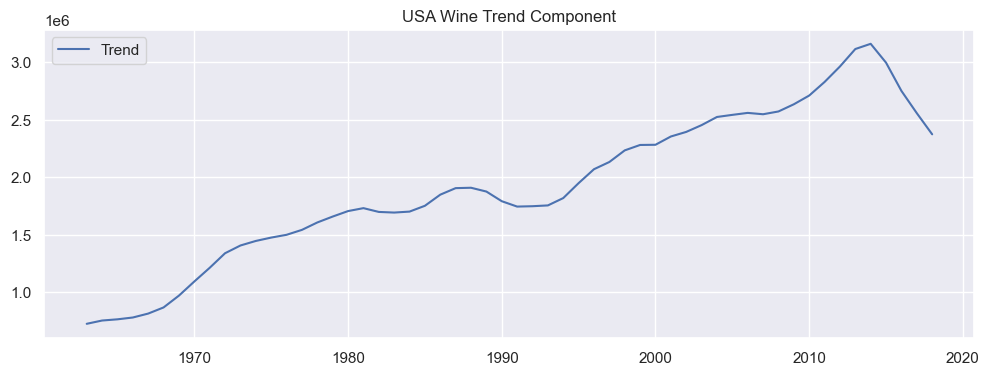

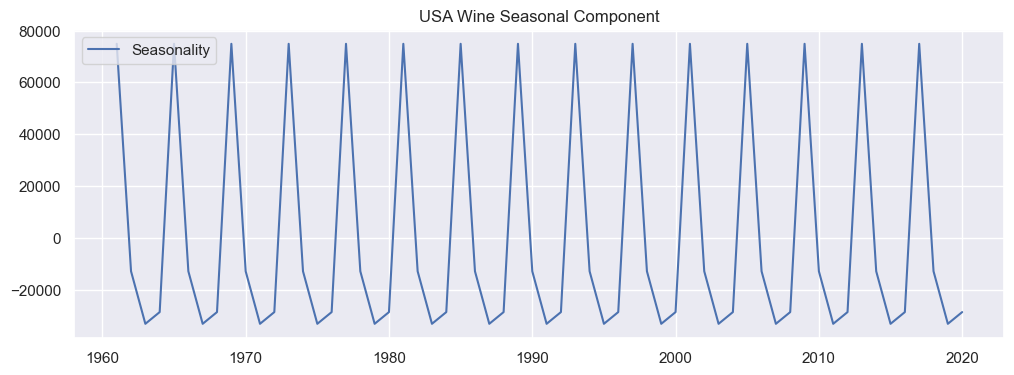

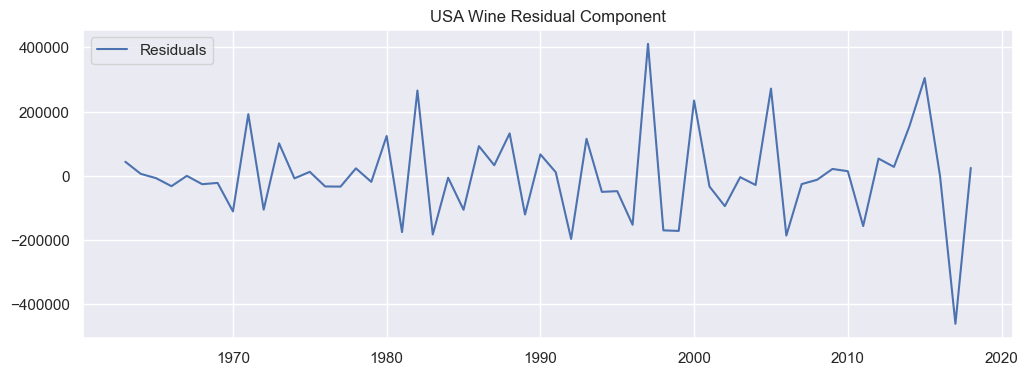

In [ ]:
# 5.1 Trend Component
plt.figure(figsize=(12, 4))
plt.plot(trend, label='Trend')
plt.title("USA Wine Trend Component")
plt.legend(loc='upper left')
plt.show()

# 5.2 Seasonal Component
plt.figure(figsize=(12, 4))
plt.plot(seasonal, label='Seasonality')
plt.title("USA Wine Seasonal Component")
plt.legend(loc='upper left')
plt.show()

# 5.3 Residual Component
plt.figure(figsize=(12, 4))
plt.plot(residual, label='Residuals')
plt.title("USA Wine Residual Component")
plt.legend(loc='upper left')
plt.show()

In [ ]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
# model = 'additive'  # or 'multiplicative'
model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequencies = [1, 5, 10, 15]

fig, axs = plt.subplots(3, 2, figsize=(18, 36))
for ii, model in enumerate(['additive', 'multiplicative']):
    for frequency in frequencies:
        decomposition = seasonal_decompose(wine[wine["Area"]=='United States of America'].Value, model=model, period=frequency)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        sns.lineplot(x=trend.index, y=trend.values, ax=axs[0,ii], label=model+" "+str(frequency))
        sns.lineplot(x=seasonal.index, y=seasonal.values, ax=axs[1,ii], label=frequency)
        sns.lineplot(x=residual.index, y=residual.values, ax=axs[2,ii], label=frequency)

sns.lineplot(x=decomposition.observed.index, y=decomposition.observed.values, ax=axs[0,0], label="original")

plt.legend()
plt.show()

### Linear Regression

**Regression by time index** <br>
As a simple approach to testing for a time-based trend, we will attempt to regress the production data by year. 

In [58]:
# Prepare dataframe with Spanish wine production data for linear regression.
spain_wine = wine[wine['Area'] == "Spain"]
spain_wine['year'] = pd.to_datetime(spain_wine.index).year.values
spain_wine['year_idx'] = spain_wine['year'] - 1961
spain_wine.head()

,Area,Value,Value_log,Value Transform,year,year_idx
Year Code,,,,,,
1961-01-01,Spain,2018400.0,14.517816,0.0,1961,0
1962-01-01,Spain,2422200.0,14.700187,403800.0,1962,1
1963-01-01,Spain,2555400.0,14.753719,133200.0,1963,2
1964-01-01,Spain,3417500.0,15.044420,862100.0,1964,3
1965-01-01,Spain,2645200.0,14.788257,-772300.0,1965,4


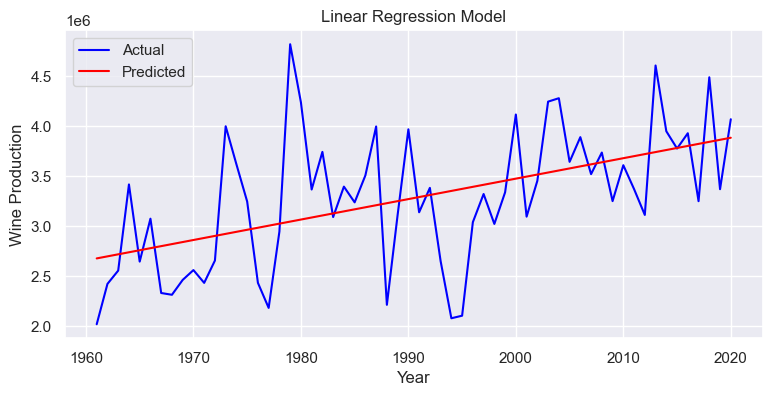

In [74]:
from sklearn.linear_model import LinearRegression
X = spain_wine['year_idx'].values.reshape(-1,1)
y = spain_wine['Value'].values
wine_reg = LinearRegression()
wine_reg.fit(X, y)

# Compute the predictions and residuals
y_pred = wine_reg.predict(X)
residuals = y - y_pred

# Compute the RMSE
rmse = np.sqrt(np.mean(residuals ** 2))

# Compute the Adjusted R-Squared
n = len(y)
p = 1
r_squared = wine_reg.score(X, y)
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Print the coefficients, intercept, RMSE, and Adjusted R-Squared
# print('Coefficients: ', wine_reg.coef_)
# print('Intercept: ', wine_reg.intercept_)
# print('RMSE: ', rmse)
# print('Adjusted R-Squared: ', adj_r_squared)

# Plot the data and regression line
plt.figure(figsize=(9,4))
plt.plot(spain_wine['year'], y, color='blue', label = "Actual")
plt.plot(spain_wine['year'], y_pred, color='red', label = "Predicted")
plt.xlabel('Year')
plt.ylabel('Wine Production')
plt.title('Linear Regression Model')
plt.legend()
plt.show()

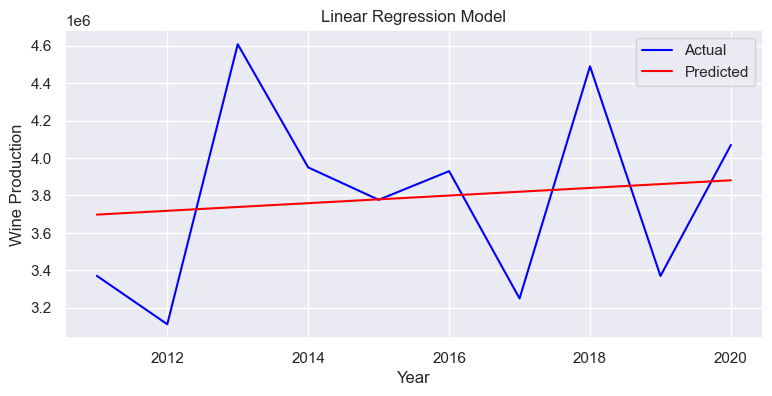

In [139]:
train = spain_wine.iloc[0:50]
test = spain_wine.iloc[50:]

X_trn = train['year_idx'].values.reshape(-1,1)
y_trn = train['Value'].values
wine_reg = LinearRegression()
wine_reg.fit(X_trn, y_trn)

# Compute the predictions and residuals
X_test = test['year_idx'].values.reshape(-1,1)
y_test = test['Value'].values
y_pred = wine_reg.predict(X_test)
residuals = y_test - y_pred

# Compute the RMSE
rmse = np.sqrt(np.mean(residuals ** 2))

# Compute the Adjusted R-Squared
n = len(y_test)
p = 1
r_squared = wine_reg.score(X_test, y_test)
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Print the coefficients, intercept, RMSE, and Adjusted R-Squared
# print('Coefficients: ', wine_reg.coef_)
# print('Intercept: ', wine_reg.intercept_)
# print('RMSE: ', rmse)
# print('Adjusted R-Squared: ', adj_r_squared)

# Plot the data and regression line
plt.figure(figsize=(9,4))
plt.plot(spain_wine['year'], y_test, color='blue', label = "Actual")
plt.plot(spain_wine['year'], y_pred, color='red', label = "Predicted")
plt.xlabel('Year')
plt.ylabel('Wine Production')
plt.title('Linear Regression Model')
plt.legend()
plt.show()

### ACF and PACF Plots

**Autocorrelation Function (ACF)** <br>
Measures the correlation between a time series and its lagged values at different time lags. Each bar represents the size and direction of the correlation.
- Identify patterns in the time series data: identify periodicity or seasonality in the time series data. 
- Test for stationarity: a stationary time series is one whose statistical properties, such as the mean and variance, do not change over time. If the ACF shows a slow decay or a trend, this suggests that the time series is non-stationary.
- Model selection: The ACF can help in selecting appropriate models for time series forecasting. For example, if the ACF shows a significant correlation at lag 1, an autoregressive model may be appropriate. If the ACF shows a significant correlation at lag 12, a seasonal autoregressive model may be appropriate.
- Detect outliers: The ACF can help detect outliers or unusual data points in the time series. If an observation has a large autocorrelation coefficient at a particular lag, this indicates that it is strongly related to previous observations at that lag and may be an outlier.

The shaded region is a confidence interval - if the height of the bars is outside this region, it means the correlation is statistically significant. <br>

**Partial autocorrelation function (PACF)** <br>
Identifies the degree of correlation between a time series and its lagged values, after controlling for the effects of all shorter lags. Is a useful tool for identifying the order of autoregressive models in time series analysis.

The PACF plot identifies the order of autoregressive (AR) models, which capture the dependence of a time series on its own past values, the PACF plot can help identify the number of significant lags in an AR model.

In practice, the PACF plot is often used in conjunction with the ACF plot to develop and refine time series models. For example, if the PACF plot shows a significant spike at lag k, and no significant spikes at higher lags, this suggests that an AR model of order k may be appropriate for the data. Conversely, if the PACF plot shows significant spikes at multiple lags, this suggests that a more complex AR model may be necessary to capture the dependence in the data.

This method tries to account for the effect the intervening lags have. For example, at lag 3, partial autocorrelation removes the effect lags 1 and 2 have on computing the correlation


**Summary**
Autocorrelation is useful for analyzing a time series's properties and choosing what type of ARIMA model to use, while partial autocorrelation tells the order of autoregressive model to fit.

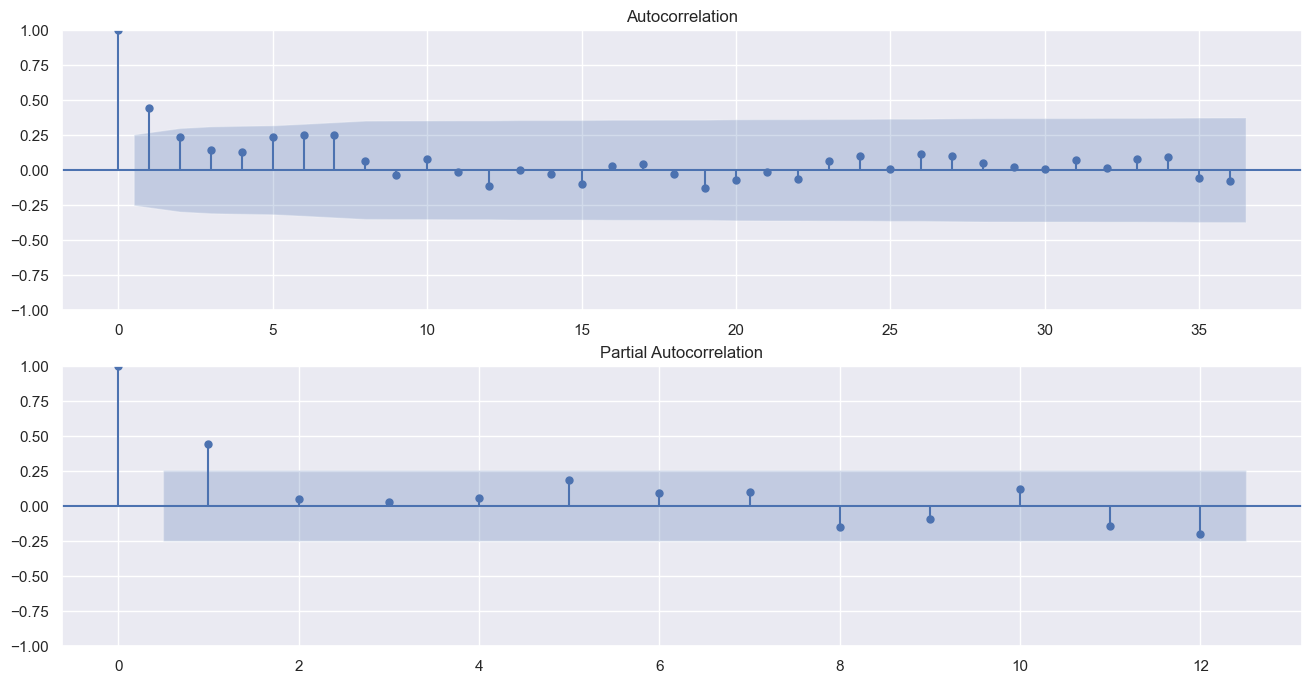

In [140]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot_acf(wine[wine['Area'] == 'Spain']['Value'], lags=36, ax=ax[0])
plot_pacf(wine[wine['Area'] == 'Spain']['Value'], lags=12, ax=ax[1], method='ywm')
plt.show()

# Models

## ARIMA (Autoregressive Integrated Moving Average) <br>
Models the relationship between a time series and its lagged values, as well as the errors or residuals of the previous predictions.

Common uses:
- Time series forecasting: widely used for forecasting future values of a time series based on its past values. It can capture trends and seasonality in the data.
- Identifying trends and seasonality: can be used to identify and estimate trends and seasonality in a time series.
- Outlier detection: used to detect outliers or unusual values in the time series. This can help identify data points that may be errors or anomalies.
- Model selection: The ARIMA model can be used to compare and select the best model for a given time series. This involves testing and comparing different ARIMA models with different parameters and selecting the model that best fits the data and gives accurate forecasts.

ARIMA needs to validate the assumption that the data is stationary, in other words that the data has a constant mean and standard deviation. To check for this assumption we could implement the Augmented Dickey-Fuller test, where the null hypothesis is that the data is non-stationary.

This model depends on 3 parameters:
- p : represents the number of lagged values of the time series that are included in the model. 
- q : represents the number of lagged errors of the time series that are included in the model. 
- d : represents the number of times that the time series is differenced to achieve stationarity.

Using Grid Search:
- p = 4 (ACF: autocorrelation function)
- d = 2 
- q = 3 (PACF: partial autocorrelation function)

The ACF and PACF plots can help identify the order of the AR and MA components. The lag at which the ACF and PACF plots first cross the significance level can indicate the order of the respective component.

Best parameters: (4, 2, 3)
Lowest MAE: 362190.09


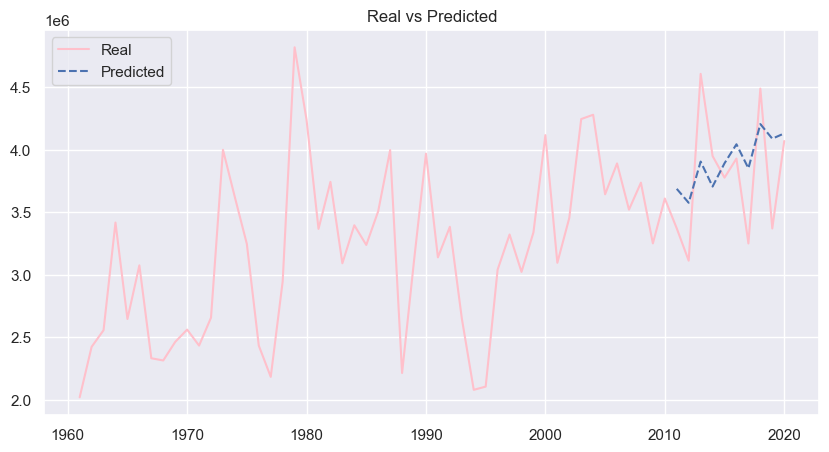

In [126]:
# Grid Search ARIMA
country = 'Spain'
value = 'Value'

# Prepare the training and testing data
train = wine[(wine['Area'] == country)].iloc[0:50]
test = wine[(wine['Area'] == country)].iloc[50:]

# Define the range of p, d, q, P, D, and Q values
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# Generate all possible combinations of p, d, q
parameter_combinations = list(itertools.product(p, d, q))

# Initialize the best model parameters and the lowest MAE
best_parameters = None
lowest_mae = float("inf")

# Train and evaluate models for each combination
for parameters in parameter_combinations:
    p, d, q = parameters
    try:
        # Fit the SARIMAX model
        model = ARIMA(train[value], order=(p, d, q))
        model_fit = model.fit()

        # Make predictions
        predictions = model_fit.predict(start=test[value].index[0], end=test[value].index[-1], typ='levels')

        # Calculate the Mean Absolute Error
        mae = mean_absolute_error(test[value], predictions)

        # Update the best parameters if the current MAE is lower than the previous lowest MAE
        if mae < lowest_mae:
            lowest_mae = mae
            best_parameters = parameters
    except:
        continue

# Print the best parameters and the lowest MAE
print(f"Best parameters: {best_parameters}")
print(f"Lowest MAE: {lowest_mae:.2f}")

# Plot best parameters
arima_model = ARIMA(train[value], order = best_parameters) 
predicted_values = arima_model_fit.predict(start=test[value].index[0], end=test[value].index[-1], typ='levels')
output = pd.concat([predicted_values, test[value]], axis=1, join="inner")

plt.figure(figsize=(10,5))
real = plt.plot(wine[(wine['Area'] == country)][value], color='pink',label='Real')
predicted = plt.plot(output.iloc[:,0], color='b', label='Predicted', linestyle='--')
plt.title('Real vs Predicted')
plt.legend(loc='best')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

country = 'Spain'
value = 'Value'

# Prepare the entire dataset
data = wine[(wine['Area'] == country)][value]

# Fit the best SARIMAX model using the best parameters
best_p, best_d, best_q, best_P, best_D, best_Q, best_s = best_parameters
best_model = SARIMAX(data, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_s))
best_model_fit = best_model.fit()

# Forecast 5, 10, 15, and 20 years into the future
n_forecast = 10
steps = n_years
forecast = best_model_fit.forecast(steps=steps)
print(f"\n{steps}-year forecast:")
print(forecast)

# Plot the historical data and forecasts
plt.plot(data.index, data, label='Historical', color='blue')

steps = n_years
forecast = best_model_fit.forecast(steps=steps)
forecast_start = forecast.index[0]
forecast_end = forecast.index[-1]
plt.plot(forecast.index, forecast, label=f'{steps}-year forecast', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical Data and Forecasts')
plt.legend()

# Show the plot
plt.show()

## SARIMA

#### Spain

In [ ]:
country = 'Spain'
value = 'Value'

# Prepare the training and testing data
training = wine[(wine['Area'] == country) & (wine.index > "1960-01-01") & (wine.index < "2011-01-01")][value]
testing = wine[(wine['Area'] == country) & ~wine.index.isin(training.index)][value]

# Define the range of p, d, q, P, D, and Q values
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P_range = range(0, 3)
D_range = range(0, 2)
Q_range = range(0, 3)
s_range = range(3, 7)

# Generate all possible combinations of p, d, q, P, D, and Q values
parameter_combinations = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range, s_range))

# Initialize the best model parameters and the lowest MAE
best_parameters = None
lowest_mae = float("inf")

# Train and evaluate models for each combination
for parameters in parameter_combinations:
    p, d, q, P, D, Q, s = parameters
    try:
        # Fit the SARIMAX model
        model = SARIMAX(training, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit()

        # Make predictions
        n_test = len(testing)
        predictions = model_fit.forecast(steps=n_test)

        # Calculate the Mean Absolute Error
        mae = mean_absolute_error(testing, predictions)

        # Update the best parameters if the current MAE is lower than the previous lowest MAE
        if mae < lowest_mae:
            lowest_mae = mae
            best_parameters = parameters
    except:
        continue

In [ ]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

country = 'Spain'
value = 'Value'

# Prepare the training and testing data
training = wine[(wine['Area'] == country) & (wine.index > "1960-01-01") & (wine.index < "2011-01-01")][value]
testing = wine[(wine['Area'] == country) & ~wine.index.isin(training.index)][value]

# Define the range of p, d, q, P, D, and Q values
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P_range = range(0, 3)
D_range = range(0, 2)
Q_range = range(0, 3)
s_range = range(3, 7)

# Generate all possible combinations of p, d, q, P, D, and Q values
parameter_combinations = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range, s_range))

# Initialize the best model parameters and the lowest MAE
best_parameters = None
lowest_mae = float("inf")

# Train and evaluate models for each combination
for parameters in parameter_combinations:
    p, d, q, P, D, Q, s = parameters
    try:
        # Fit the SARIMAX model
        model = SARIMAX(training, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit()

        # Make predictions
        n_test = len(testing)
        predictions = model_fit.forecast(steps=n_test)

        # Calculate the Mean Absolute Error
        mae = mean_absolute_error(testing, predictions)

        # Update the best parameters if the current MAE is lower than the previous lowest MAE
        if mae < lowest_mae:
            lowest_mae = mae
            best_parameters = parameters
    except:
        continue

# Print the best parameters and the lowest MAE
print(f"Best parameters: {best_parameters}")
print(f"Lowest MAE: {lowest_mae:.2f}")

In [ ]:
# Print the best parameters and the lowest MAE
print(f"Best parameters: {best_parameters}")
print(f"Lowest MAE: {lowest_mae:.2f}")

In [ ]:
# Fit the best SARIMAX model using the best parameters
best_p, best_d, best_q, best_P, best_D, best_Q, best_s = best_parameters
best_model = SARIMAX(training, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_s))
best_model_fit = best_model.fit()

# Make predictions with the best model
n_test = len(testing)
best_predictions = best_model_fit.forecast(steps=n_test)

In [ ]:
# Plot the actual and predicted values
plt.plot(testing.index, testing, label='Actual', color='blue')
plt.plot(testing.index, best_predictions, label='Predicted', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()

# Show the plot
plt.show()

#### United States of America

In [436]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

country = 'United States of America'
value = 'Value'

# Prepare the training and testing data
training = wine[(wine['Area'] == country) & (wine.index > "1960-01-01") & (wine.index < "2011-01-01")][value]
testing = wine[(wine['Area'] == country) & ~wine.index.isin(training.index)][value]

# Define the range of p, d, q, P, D, and Q values
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P_range = range(0, 3)
D_range = range(0, 2)
Q_range = range(0, 3)
s_range = range(3, 7)

# Generate all possible combinations of p, d, q, P, D, and Q values
parameter_combinations = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range, s_range))

# Initialize the best model parameters and the lowest MAE
best_parameters = None
lowest_mae = float("inf")

# Train and evaluate models for each combination
for parameters in parameter_combinations:
    p, d, q, P, D, Q, s = parameters
    try:
        # Fit the SARIMAX model
        model = SARIMAX(training, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit()

        # Make predictions
        n_test = len(testing)
        predictions = model_fit.forecast(steps=n_test)

        # Calculate the Mean Absolute Error
        mae = mean_absolute_error(testing, predictions)

        # Update the best parameters if the current MAE is lower than the previous lowest MAE
        if mae < lowest_mae:
            lowest_mae = mae
            best_parameters = parameters
    except:
        continue

# Print the best parameters and the lowest MAE
print(f"Best parameters: {best_parameters}")
print(f"Lowest MAE: {lowest_mae:.2f}")

In [ ]:
# Print the best parameters and the lowest MAE
print(f"Best parameters: {best_parameters}")
print(f"Lowest MAE: {lowest_mae:.2f}")

In [ ]:
# Fit the best SARIMAX model using the best parameters
best_p, best_d, best_q, best_P, best_D, best_Q, best_s = best_parameters
best_model = SARIMAX(training, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_s))
best_model_fit = best_model.fit()

# Make predictions with the best model
n_test = len(testing)
best_predictions = best_model_fit.forecast(steps=n_test)

In [ ]:
# Plot the actual and predicted values
plt.plot(testing.index, testing, label='Actual', color='blue')
plt.plot(testing.index, best_predictions, label='Predicted', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()

# Show the plot
plt.show()

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
# Seperate data into training and testing 
from sklearn.model_selection import train_test_split

train_size = int(len(wine2) * 0.8)
train_data, test_data = wine2[:train_size], wine2[train_size:]

# use train_test_split to split the data
X_train, X_test, y_train, y_test = train_test_split(wine2, wine2[:, -1], test_size=0.2, shuffle=False)

InvalidIndexError: (slice(None, None, None), -1)

## Meta Prophet

In [ ]:
from prophet import Prophet

country = 'Spain'
value = 'Value'

# Prepare the data
data = wine[(wine['Area'] == country)][value]
data = data.reset_index()
data.columns = ['ds', 'y']  # Prophet requires columns to be named 'ds' (dates) and 'y' (values)

# Split the data into training and testing sets
train_data = data[data['ds'] < "2011-01-01"]
test_data = data[data['ds'] >= "2011-01-01"]

# Create and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Make predictions
future = model.make_future_dataframe(periods=len(test_data), freq='AS-JAN')
forecast = model.predict(future)

# Visualize the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data['ds'], data['y'], label='Actual', color='blue')
ax.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)
ax.set(xlabel='Date', ylabel='Value', title='Facebook Prophet Forecast')
plt.legend()
plt.show()

### FORECASTING

In [ ]:
import matplotlib.pyplot as plt

country = 'Spain'
value = 'Value'

# Prepare the entire dataset
data = wine[(wine['Area'] == country)][value]

# Fit the best SARIMAX model using the best parameters
best_p, best_d, best_q, best_P, best_D, best_Q, best_s = best_parameters
best_model = SARIMAX(data, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_s))
best_model_fit = best_model.fit()

# Forecast 5, 10, 15, and 20 years into the future
n_forecast = 10
steps = n_years
forecast = best_model_fit.forecast(steps=steps)
print(f"\n{steps}-year forecast:")
print(forecast)

# Plot the historical data and forecasts
plt.plot(data.index, data, label='Historical', color='blue')

steps = n_years
forecast = best_model_fit.forecast(steps=steps)
forecast_start = forecast.index[0]
forecast_end = forecast.index[-1]
plt.plot(forecast.index, forecast, label=f'{steps}-year forecast', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical Data and Forecasts')
plt.legend()

# Show the plot
plt.show()